In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
from torch import nn, optim, autograd
import numpy as np
import random
from matplotlib import pyplot as plt

In [4]:
import visdom

In [5]:
h_dim = 400
batch_size = 512
viz =  visdom.Visdom()

class Generator(nn.Module):
    
    def __init__(self):
        super(Generator,self).__init__()
        
        self.net = nn.Sequential(
            #z: [batch_size, 2] => [b, 2]输出学习的分布，为了画出就定二维,四全连接层
            nn.Linear(2, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, 2),
        )
        
    def forward(self, z):
        output = self.net(z)
        return output
    
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.net = nn.Sequential(
            #z: [batch_size, 2] => [b, 2]输出学习的分布，为了画出就定二维,四全连接层
            nn.Linear(2, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        output = self.net(z)
        return output.view(-1)

    #生成数据集
def data_generator():
    #八个高斯混合分布。在一个圆上 
    scale = 2.
    centers = [
        (1, 0),
        (-1, 0),
        (0, -1),
        (0, 1),
        (1./np.sqrt(2), 1./np.sqrt(2)),
        (1./np.sqrt(2), -1./np.sqrt(2)),
        (-1./np.sqrt(2), 1./np.sqrt(2)),
        (-1./np.sqrt(2), -1./np.sqrt(2))
    ]
    centers = [(scale * x, scale * y) for x,y in centers]
    
    while True:
        dataset = []
        
        for i in range(batch_size):
            point = np.random.randn(2)*0.01
            center = random.choice(centers)
            #N(0,1) + center x1/x2
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
            
        dataset = np.array(dataset).astype(np.float32)
        dataset /=1.414
        #迭代返回生成器
        yield dataset

Setting up a new session...


In [28]:
def generate_image(D, G, xr, epoch):
    """
    Generates and saves a plot of the true distribution, the generator, and the
    critic.
    """
    N_POINTS = 128
    RANGE = 3
    plt.clf()

    points = np.zeros((N_POINTS, N_POINTS, 2), dtype='float32')
    points[:, :, 0] = np.linspace(-RANGE, RANGE, N_POINTS)[:, None]
    points[:, :, 1] = np.linspace(-RANGE, RANGE, N_POINTS)[None, :]
    points = points.reshape((-1, 2))
    # (16384, 2)
    # print('p:', points.shape)

    # draw contour
    with torch.no_grad():
        points = torch.Tensor(points).cuda() # [16384, 2]
        disc_map = D(points).cpu().numpy() # [16384]
    x = y = np.linspace(-RANGE, RANGE, N_POINTS)
    cs = plt.contour(x, y, disc_map.reshape((len(x), len(y))).transpose())
    plt.clabel(cs, inline=1, fontsize=10)
    # plt.colorbar()


    # draw samples
    with torch.no_grad():
        z = torch.randn(batch_size, 2).cuda() # [b, 2]
        samples = G(z).cpu().numpy() # [b, 2]
    xr = xr.cpu().numpy()
    plt.scatter(xr[:, 0], xr[:, 1], c='orange', marker='.')
    plt.scatter(samples[:, 0], samples[:, 1], c='green', marker='+')

    viz.matplot(plt, win='contour', opts=dict(title='p(x):%d'%epoch))

In [29]:
def main():
    torch.manual_seed(24)
    np.random.seed(24)
    data_iter = data_generator()
    x = next(data_iter)
    
    G = Generator().cuda()
    D = Discriminator().cuda()
    print(G)
    print(D)
    optim_G = optim.Adam(G.parameters(), lr=5e-4, betas=(0.5, 0.9))
    optim_D = optim.Adam(D.parameters(), lr=5e-4, betas=(0.5, 0.9))
    
    viz.line([[0,0]],[0], win='loss', opts=dict(title='loss',legend = ['D','G']))
    
    for epoch in range(5000):
        
        #先训练Discriminator
        #k个step
        for _ in range(5):
            
            x_real = next(data_iter)
            
            x_real = torch.from_numpy(x_real).cuda()
            # [b,2] -> [b, 1]
            pred_ture = D(x_real)
            
            loss_real = -pred_ture.mean()
            
            # 生成数据g
            z = torch.randn(batch_size, 2).cuda()
            
            x_fake = G(z).detach()
            
            pred_fake = D(x_fake)
            
            loss_fake = pred_fake.mean()
            
            loss_D = loss_real + loss_fake
            
            optim_D.zero_grad()
            loss_D.backward()
            optim_D.step()
            
            
        # train Generator
        
        z = torch.randn(batch_size, 2).cuda()
        x_fake = G(z)
        pred_fake = D(x_fake)
        #最大化
        loss_G = -pred_fake.mean()
        
        #optimze
        optim_G.zero_grad()
        loss_G.backward()
        optim_G.step()
        
        if epoch % 100 ==0:
            #print(loss_D.item(), loss_G.item())
            viz.line([[loss_D.item(), loss_G.item()]], [epoch], win='loss', update= 'append')
            
            generate_image(D, G, x_real,epoch)

Generator(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=400, out_features=400, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=400, out_features=2, bias=True)
  )
)
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=400, out_features=400, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=400, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


KeyboardInterrupt: 

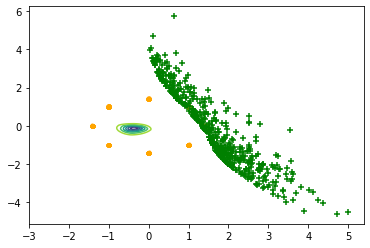

In [30]:
if __name__ == "__main__":
    main()